### Problem 1

## Identifying dog images
The goal of this assignment is to develop models which will identify the breeds of dogs. For the dataset, you are provided with a set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. One goal of this assignment is to create a multiclass classifier capable of determining a dog's breed from a photo.

Since we do not have the labels for the test set, we will only use the files `training.zip` and `label.csv` for training and validation.

Also, the **entire assignment should be run on Colab**. Even our means of obtaining the data is going to be specific to the Google ecosystem.


### Loading Libraries
We begin by loading the functions we'll need throughout the assignment:
```python
import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers

from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from zipfile import ZipFile
import time
from datetime import timedelta
from io import BytesIO

# Image manipulation.
import PIL.Image

import pickle
import os

import random
```


In [9]:
import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers

from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from zipfile import ZipFile
import time
from datetime import timedelta
from io import BytesIO

# Image manipulation.
import PIL.Image

import pickle
import os

import random

® [5 points] What's the difference between `AveragePooling2D` and `GlobalAveragePooling2D`? The code snippet below might be helpful, as might the TensorFlow documentation.
```python
import tensorflow as tf
input_shape = (20, 40, 50, 10)
x = tf.random.normal(input_shape)
print(tf.keras.layers.GlobalAveragePooling2D()(x).shape)
print(tf.keras.layers.AveragePooling2D()(x).shape)
```


In [10]:
import tensorflow as tf
input_shape = (20, 40, 50, 10)
x = tf.random.normal(input_shape)
print(tf.keras.layers.GlobalAveragePooling2D()(x).shape)
print(tf.keras.layers.AveragePooling2D()(x).shape)

(20, 10)
(20, 20, 25, 10)


The output of GlobalAveragePooling2D is in 2 dimenion. The form of the output is [batch_size, channels]. It calculates the average of the whole input and it only returns average as the output, so the dimension reduces.

The output of AveragePooling2D us is in four dimension. The form of the output is [batch_size, channels, pooled_rows, pooled_cols]. It has 2*2 pool size which contains the averaged height and width.

### Problem 2

### Mounting the Google Drive
Before training a model, we must first get the data on the machine running our Colab session. To do this, we will _mount_ the Google Drive associated with your Brown account. This just means making your drive available as a directory on the Colab machine, particularly at the location `/content/drive`. If you want, you can inspect the file system of the Colab machine using the folder icon on the toolbar on the left edge of the window.

This will require a couple manual steps: 

1. Visit [this URL](https://drive.google.com/drive/folders/1wWF4txn6hRfE4ofG1J4ZdsCrV1HpRbEZ?usp=sharing) and add a shortcut to your "My Drive".
2. Note: after this HW assignment, you can delete these shortcut to keep your GDrive tidy. If you want to put it somewhere else in your GDrive now, you will need to change the variable `path` accordingly.
3. Run the code cell below to mount the drive. You'll have to authenticate in a separate window and copy an authentication code back to this page.


```python
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Data/"
```


In [11]:
os.getcwd()

'/content'

In [12]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Unzip the zip file for the training data
The training data comes in the form of a zip file containing many image files. We can access these file names using the `namelist` method of the `ZipFile` object produced below.


```python
archive_train = ZipFile(path + "train.zip", 'r')
```


In [13]:
archive_train = ZipFile(path + "train.zip", 'r')

In [14]:
len(list(archive_train.namelist()))

10222

® How many files do we have in the training set? Note that the object returned by the `namelist` method is a generator, so you will have to convert it to a `list` to find its length.


There are 10222 files in the training set.

### Problem 3

### Reading the Labels
The label.csv should contain two columns: `id` and `breed`.


```python
labels_raw = pd.read_csv(path + "labels.csv", 
                         header=0, sep=',', quotechar='"')
# Look at the first five rows:
labels_raw.head(5)
```


In [15]:
labels_raw = pd.read_csv(path + "labels.csv", 
                         header=0, sep=',', quotechar='"')
# Look at the first five rows:
labels_raw.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


® How many images do we have for each breed in this dataset? Hint: investigate the Pandas method `value_counts`.


In [16]:
labels_raw['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

It contains 120 breeds in the dataset.

The most common breed is `scottish_deerhound`, which has 126 images and the least common breed is `briard`, which has 66 images.

### Problem 4

Let's make a visualization for the collection of counts for each breed:


```python
ax = (labels_raw.value_counts(labels_raw['breed'], ascending=True)
                 .plot(kind='barh', fontsize="20", 
                       title="Class Distribution", figsize=(15,40)))

ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(30)
plt.show()
```


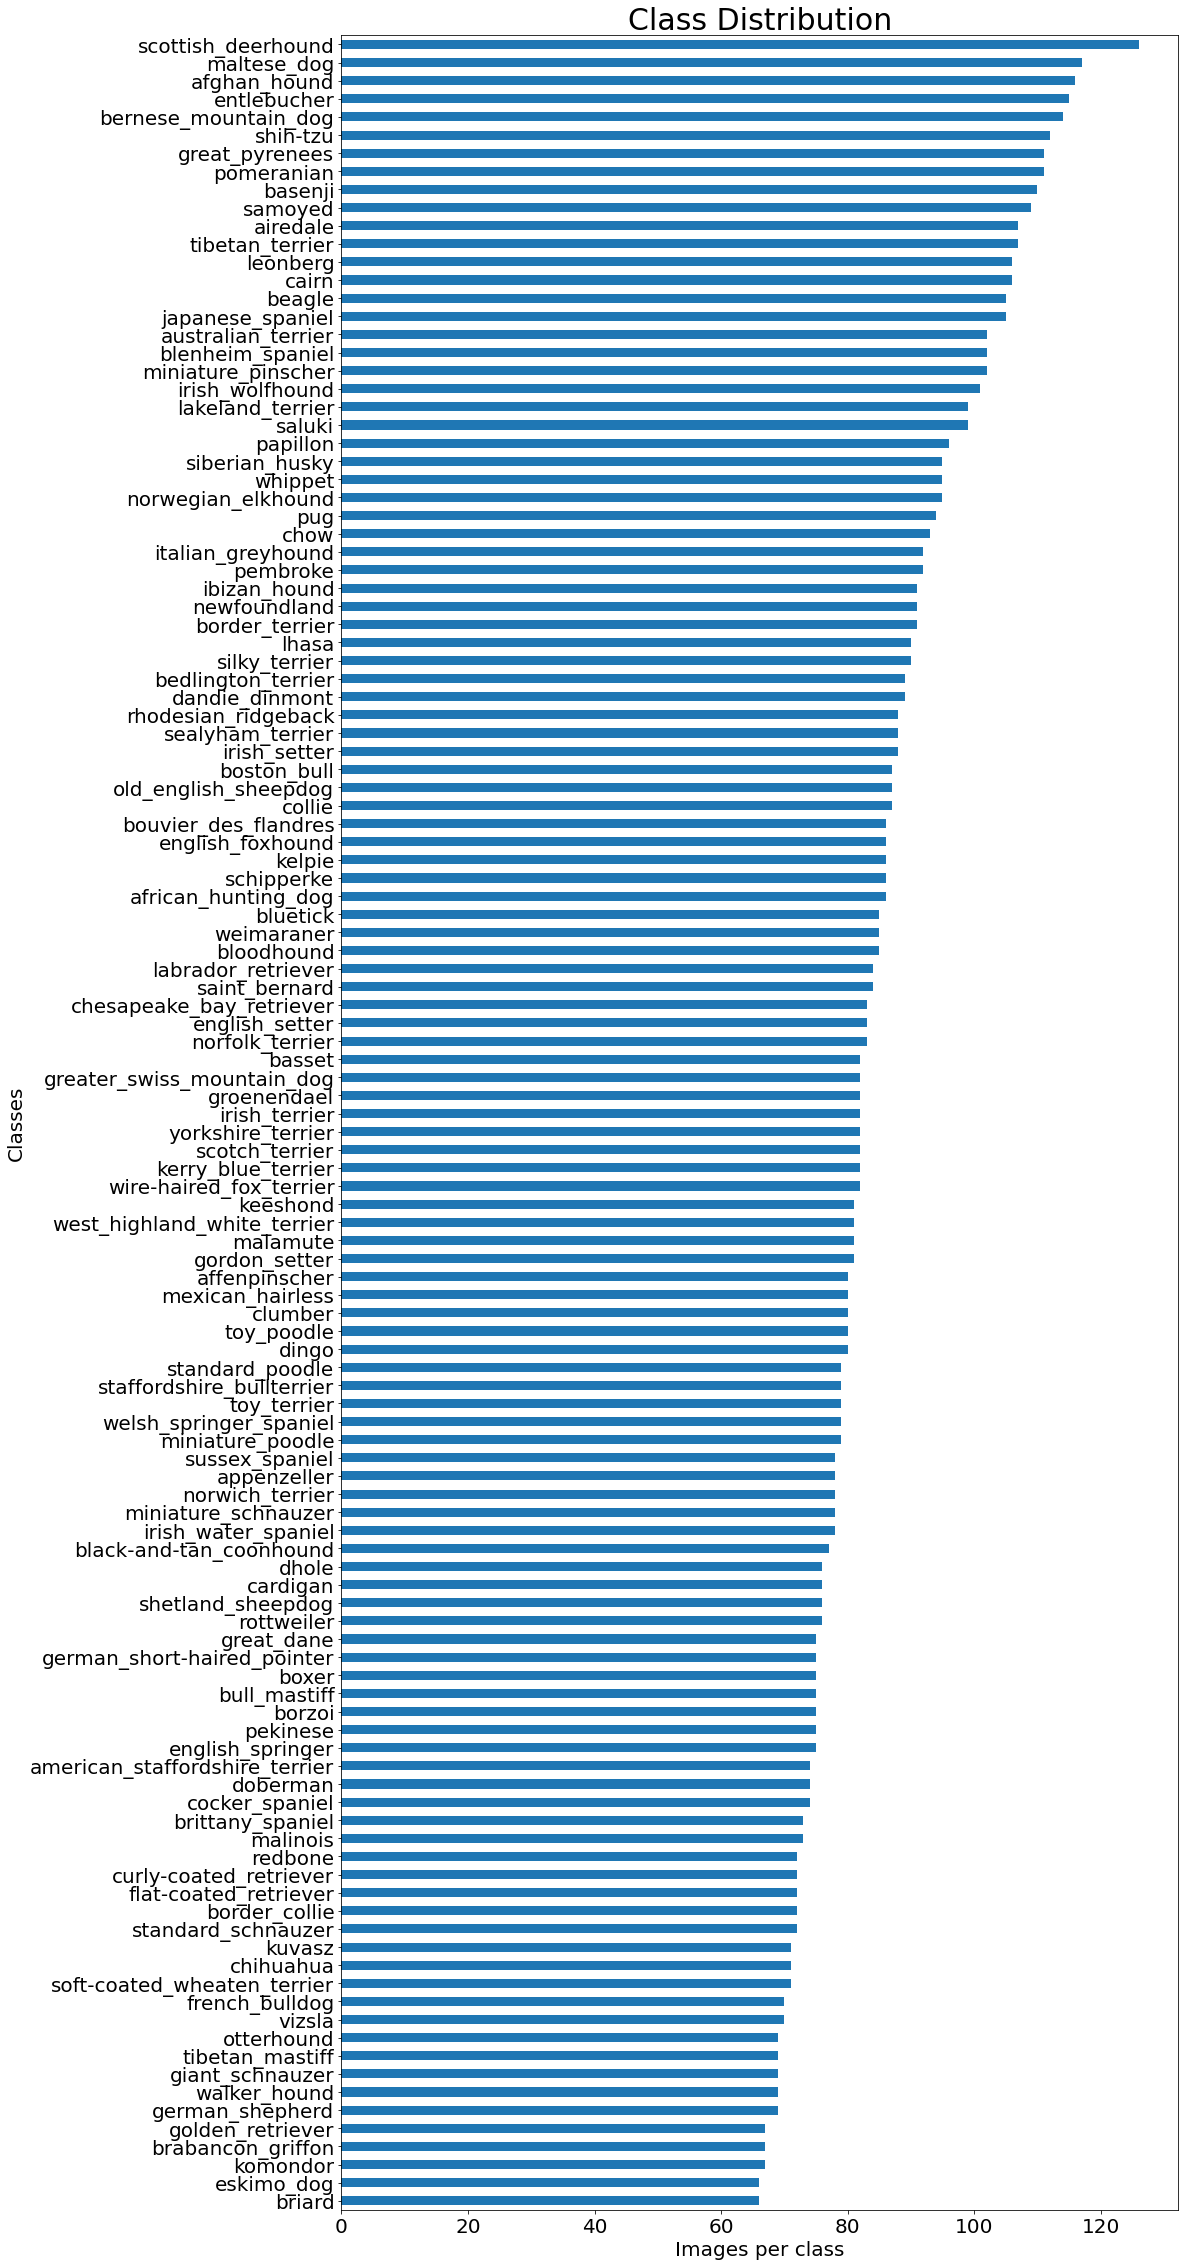

In [17]:
ax = (labels_raw.value_counts(labels_raw['breed'], ascending=True)
                 .plot(kind='barh', fontsize="20", 
                       title="Class Distribution", figsize=(15,40)))

ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(30)
plt.show()

### Extracting and Organizing
Next, we will create a NumPy `ndarray` for all of the images and store the array using Python's `pickle` module. We will compress the images to a smaller dimension due to limited computational resources. It takes 1-2 minutes to create this pickle file due to the large number of images. The pickle file is saved in the temporary folder and will be deleted if you lose connection to the kernel. You can also modify the saving folder yourself to save it somewhere in your GDrive so you can directly read the file later.

_Note: making pickle files is like writing Python data structures directly to disk from your Python session. They're high-fidelity and efficient for Python, but they're not really useful for anything other than loading back into a Python session._


```python
# images will be re-sized to 96 by 96:
image_resize = 96
```


In [18]:
# images will be re-sized to 96 by 96:
image_resize = 96

```python
def pickle_creator(archivezip, nwidth, nheight, save_name):
    # We choose the archive (zip file) + the new nwidth and height for all the image which will be reshaped
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    s = (len(archivezip.namelist()[:])-1, nwidth, nheight,3) # nwidth x nheight = number of features because images are nwigth x nheight pixels
    allImage = np.zeros(s)
    labels = np.empty(len(archivezip.namelist()[:])-1, dtype = "object")
    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) #255 = max of the value of a pixel

        allImage[i-1]=image
        labels[i-1]=list(labels_raw[labels_raw['id']==archivezip.namelist()[i][:-4]]['breed'])[0]
    # we save the newly created data
    pickle.dump(allImage, open( save_name + '.pickle', "wb" ,) ,protocol=4)
    pickle.dump(labels, open( save_name + 'labels' + '.pickle', "wb" ),protocol=4 )
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print how much time it took:
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))
```


In [19]:
def pickle_creator(archivezip, nwidth, nheight, save_name):
    # We choose the archive (zip file) + the new nwidth and height for all the image which will be reshaped
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    s = (len(archivezip.namelist()[:])-1, nwidth, nheight,3) # nwidth x nheight = number of features because images are nwigth x nheight pixels
    allImage = np.zeros(s)
    labels = np.empty(len(archivezip.namelist()[:])-1, dtype = "object")
    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) #255 = max of the value of a pixel

        allImage[i-1]=image
        labels[i-1]=list(labels_raw[labels_raw['id']==archivezip.namelist()[i][:-4]]['breed'])[0]
    # we save the newly created data
    pickle.dump(allImage, open( save_name + '.pickle', "wb" ,) ,protocol=4)
    pickle.dump(labels, open( save_name + 'labels' + '.pickle', "wb" ),protocol=4 )
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print how much time it took:
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

```python
pickle_creator(archivezip = archive_train, nwidth = image_resize, nheight = image_resize , save_name = "/content/drive/MyDrive/train")
```


In [20]:
pickle_creator(archivezip = archive_train, nwidth = image_resize, nheight = image_resize , save_name = "/content/drive/MyDrive/train")

Time elapsed: 0:02:32


® Show a couple of the original images side-by-side with their re-sized versions. What algorithm is Pillow using to downsample the images?


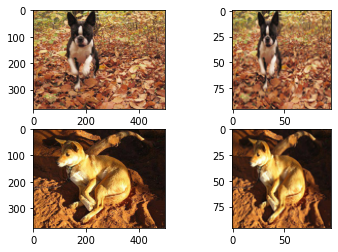

In [21]:
for i in range(2):
  num = 220 + (i+i+1)
  plt.subplot(num)
  filename = BytesIO(archive_train.read(archive_train.namelist()[i]))
  image = PIL.Image.open(filename) # open colour image
  plt.imshow(image)

  num = 220 + (i+i+2)
  plt.subplot(num)
  image = image.resize((image_resize, image_resize))
  image = np.array(image)
  image = np.clip(image/255.0, 0.0, 1.0) #255 = max of the value of a pixel
  plt.imshow(image)

The method is used to resample the images is the default one in `image.resize` function, which is `PIL.Image.BICUBIC`. This method uses cubic interpolation on all pixels to resize the image.

### Problem 5

Now let's load our training data:


```python
train = pickle.load( open( "/content/drive/MyDrive/train.pickle", "rb" ) )
labels = pickle.load( open( "/content/drive/MyDrive/trainlabels.pickle", "rb" ) )
print(train.shape)
print(labels.shape)
```


In [22]:
train = pickle.load( open( "/content/drive/MyDrive/train.pickle", "rb" ) )
labels = pickle.load( open( "/content/drive/MyDrive/trainlabels.pickle", "rb" ) )
print(train.shape)
print(labels.shape)

(10221, 96, 96, 3)
(10221,)


### Select the top 16 breeds for this homework
® Write code to select the 16 most-represented dog breeds in the dataset for this homework. So this will be a 16-class classification problem.

Apart from this homework, you are welcome to see how it changes things to increase or decrease the number of breeds. However, for now let's stick to 16.

To help make sure you're on the right track, the result of your code for this problem should be to define a variable called `labels_filtered` which contains 1777 labels and another variable called `train_filtered` which contains a 1777 by 96 by 96 by 3 array. You can sanity check further using this snippet, which will show some of the images alongside the corresponding label:
```python
for i in range(5):
  random_index = random.randint(1,len(labels_filtered))
  print(labels_filtered[random_index])
  lum_img = train_filtered[random_index,:,:,:]
  plt.imshow(lum_img)
  plt.show()
```
Also, be sure to define `n_breeds = 16`, as we'll use that variable later.


In [23]:
n_breeds = 16
index = [i for i in range(len(labels)) if labels[i] in labels_raw['breed'].value_counts().head(n_breeds).index]

In [24]:
train_filtered = train[index,:,:,:]
labels_filtered = labels[index]

shih-tzu


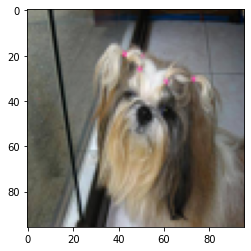

scottish_deerhound


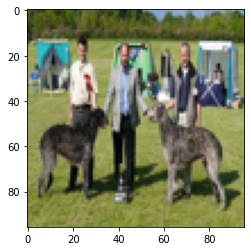

beagle


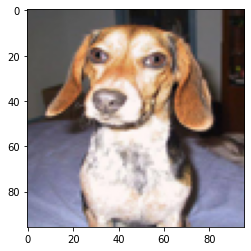

entlebucher


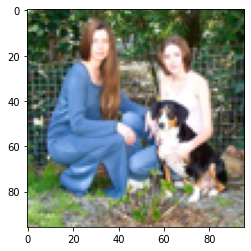

japanese_spaniel


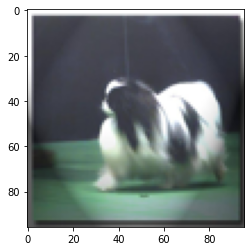

In [25]:
for i in range(5):
  random_index = random.randint(1,len(labels_filtered))
  print(labels_filtered[random_index])
  lum_img = train_filtered[random_index,:,:,:]
  plt.imshow(lum_img)
  plt.show()

### Problem 6

### Train-test Split and Data Generator
We will take 80% of the data as training and 20% as validation. We will use `ImageDataGenerator` to fit the data in the model. Keras `ImageDataGenerator` class provides a quick and easy way to augment your images. It provides a host of different augmentation techniques like standardization, rotation, shifts, flips, brightness change, and many more. You can find more on its official [documentation page](https://keras.io/api/preprocessing/image/).


We'll begin by reshaping the `labels` array and representing it as a dense, 16-column array:


```python
labels = labels_filtered
labels = labels.reshape(labels.shape[0],1)
labels = pd.get_dummies(labels_filtered)
labels.shape
```


In [26]:
labels = labels_filtered
labels = labels.reshape(labels.shape[0],1)
labels = pd.get_dummies(labels_filtered)
labels.shape

(1777, 16)

Next, let's double-check all of the dimensions of the tensors involved:


```python
random.seed(2040)
X = train_filtered
y = labels
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
```


In [27]:
random.seed(2040)
X = train_filtered
y = labels
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1777, 96, 96, 3)
(1777, 16)
(1421, 96, 96, 3)
(1421, 16)
(356, 96, 96, 3)
(356, 16)


And now we'll create the data generator:


```python
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()
```


In [28]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

® What's the difference between a generator and an iterable (in Python parlance)? Which is `ImageDataGenerator` (hint: might be a trick question!)? 

Why is this distinction particularly relevant in this context?


A generator could help to save memory than an iterable. An iterable would save data into memory as variabel. A generator would only load the data while training the model and would discard the data after the training.

ImageDataGenerator is a generator to generate the images as data points with reflection, rotation and sent them to train the model in each batch. 

It is particularly relevant in this context because for image classification, we would not only expect the model to recognize the breeds of the original images, but also could recogize the breeds when the image is rotated or reflected. Also, the dataset of image could take a lot of memory when it is loaded as iterable. Using ImageDataGenerator could help to save memory and make it easy to generate new sample.

The data generator consume less memory than an iteratble of the same dataset. While we need more data the the original dataset to train our model, like a rotation of a image can also be a good training data point, loading all of them into memory will be a disaster as dataset get large. 

The ImageDataGenerator helps to generate those augmented data points like reflection, rotation and sento them to train in each batch. 

Therefore, the memory of the machine is saved. This distinction is especially relevant as Image is easy to transform to generate a new sample.

### Problem 7

### Models and Training


To train this model, we'll begin by batching the data output by the image generator:


```python
BATCH_SIZE = 10 # You can modify this
training_set = train_datagen.flow(X_train, y=y_train, batch_size=BATCH_SIZE)
testing_set = test_datagen.flow(X_test, y=y_test, batch_size=BATCH_SIZE)
```


In [29]:
BATCH_SIZE = 10 # You can modify this
training_set = train_datagen.flow(X_train, y=y_train, batch_size=BATCH_SIZE)
testing_set = test_datagen.flow(X_test, y=y_test, batch_size=BATCH_SIZE)

#### Model 1: Basic CNN Model
In this task, the basic CNN archtecture should be as followed :
- Convolutional Layer with 32 filters which are each $3 \times 3$a.


- Max pooling
- Relu


- Convolutional Layer with 3 by 3 filters (64 of them)


- Max pooling
- Relu


- Convolutional Layer with 3*3 filters (128 of them)


- Max pooling
- Relu
- DropOut Rate 0.2


- Flatten Layer
- Fully Connected Layer with 500 nodes


- Relu
- DropOut Rate 0.2


- Fully Connected Layer with n nodes (n = number of breeds) and softmax activation


```python
def build_model():
  inputs = Input(shape = (image_resize, image_resize, 3))
  model = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(image_resize, image_resize, 3))(inputs)

  model = MaxPool2D(pool_size=(2, 2))(model)
  model = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01))(model)
  model = MaxPool2D(pool_size=(2, 2))(model)
  model = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01))(model)
  model = MaxPool2D(pool_size=(2, 2))(model)
  model = Dropout(rate=0.2)(model)
  # model = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01))(model)
  # model = MaxPool2D(pool_size=(2, 2))(model)
  # model = Dropout(rate=0.2)(model)
  model = Flatten()(model)
  model = Dense(500, activation = "relu", kernel_initializer="he_normal")(model)
  model = Dropout(rate=0.2)(model)
  # model = Dense(100, activation = "relu", kernel_initializer="he_normal")(model)
  out = Dense(n_breeds, activation = 'softmax')(model)
  model = Model(inputs=inputs, outputs=out)
  return model

model = build_model()

opt = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss=categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
model.summary()
```


In [30]:
def build_model():
  inputs = Input(shape = (image_resize, image_resize, 3))
  model = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(image_resize, image_resize, 3))(inputs)

  model = MaxPool2D(pool_size=(2, 2))(model)
  model = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01))(model)
  model = MaxPool2D(pool_size=(2, 2))(model)
  model = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01))(model)
  model = MaxPool2D(pool_size=(2, 2))(model)
  model = Dropout(rate=0.2)(model)
  # model = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01))(model)
  # model = MaxPool2D(pool_size=(2, 2))(model)
  # model = Dropout(rate=0.2)(model)
  model = Flatten()(model)
  model = Dense(500, activation = "relu", kernel_initializer="he_normal")(model)
  model = Dropout(rate=0.2)(model)
  # model = Dense(100, activation = "relu", kernel_initializer="he_normal")(model)
  out = Dense(n_breeds, activation = 'softmax')(model)
  model = Model(inputs=inputs, outputs=out)
  return model

model = build_model()

opt = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(loss=categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0     

Now we'll train the model:


```python
history = model.fit(
  training_set, 
  steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
  validation_data = testing_set, 
  epochs = 100, 
  verbose = 1
)
```


In [31]:
history = model.fit(
  training_set, 
  steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
  validation_data = testing_set, 
  epochs = 100, 
  verbose = 1
)

Epoch 1/100
142/142 [==============================] - 8s 36ms/step - loss: 4.0457 - accuracy: 0.0476 - val_loss: 3.8297 - val_accuracy: 0.0955
Epoch 2/100
142/142 [==============================] - 4s 27ms/step - loss: 3.7658 - accuracy: 0.0758 - val_loss: 3.6087 - val_accuracy: 0.0449
Epoch 3/100
142/142 [==============================] - 4s 27ms/step - loss: 3.5509 - accuracy: 0.0887 - val_loss: 3.4237 - val_accuracy: 0.0787
Epoch 4/100
142/142 [==============================] - 4s 27ms/step - loss: 3.3659 - accuracy: 0.1183 - val_loss: 3.2625 - val_accuracy: 0.1236
Epoch 5/100
142/142 [==============================] - 4s 27ms/step - loss: 3.2578 - accuracy: 0.1410 - val_loss: 3.1364 - val_accuracy: 0.1152
Epoch 6/100
142/142 [==============================] - 4s 28ms/step - loss: 3.1303 - accuracy: 0.1516 - val_loss: 3.0099 - val_accuracy: 0.1742
Epoch 7/100
142/142 [==============================] - 4s 27ms/step - loss: 3.0570 - accuracy: 0.1525 - val_loss: 2.9574 - val_accuracy:

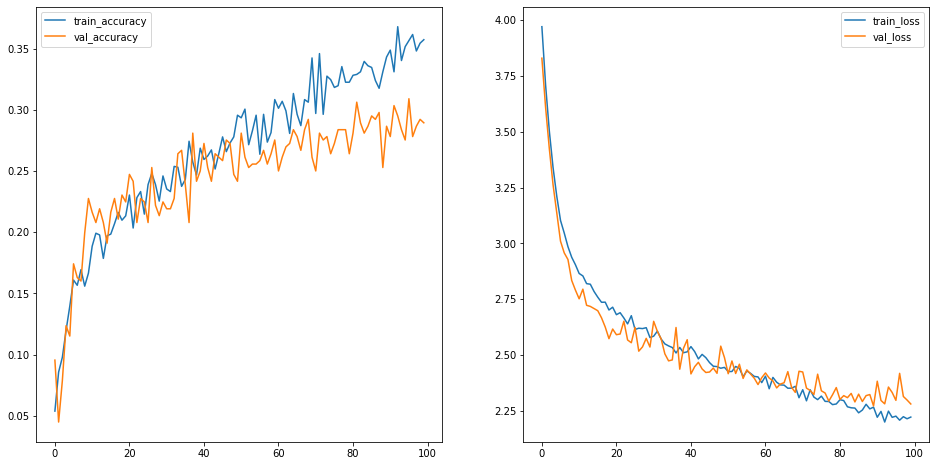

In [32]:
fig, axes = plt.subplots(1, 2, figsize =(16, 8))
axes[0].plot(history.history['accuracy'], label='train_accuracy')
axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
axes[0].legend()
axes[1].plot(history.history['loss'], label='train_loss')
axes[1].plot(history.history['val_loss'], label='val_loss')
axes[1].legend()
plt.show()

#### Model 2
® Slightly modify the CNN structure we built above. Feel free to add up to two convolutional layers and adjust the dropout rate, change the activation function and add regularization. 

```python
def build_model_own():

  #### TASK: Build your own model here ####

  return model

my_model = build_model_own()

opt = keras.optimizers.Adam(learning_rate=0.00005)

my_model.compile(loss=categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

print(my_model.summary())

history_mymodel = my_model.fit(
  training_set, 
  steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
  validation_data = testing_set, 
  epochs = 100, 
  verbose = 1
)
```


In [33]:
def build_model_own():

  inputs = Input(shape = (image_resize, image_resize, 3))
  #layer 1
  model = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.001), input_shape=(image_resize, image_resize, 3))(inputs)
  model = MaxPool2D(pool_size=(2, 2))(model)
  #layer 2
  model = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.001))(model)
  model = MaxPool2D(pool_size=(2, 2))(model)
  #layer 3
  model = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.001))(model)
  model = MaxPool2D(pool_size=(2, 2))(model)
  model = Dropout(rate=0.25)(model)
  #layer 4
  model = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.001))(model)
  model = MaxPool2D(pool_size=(2, 2))(model)
  model = Dropout(rate=0.25)(model)
  model = Flatten()(model)
  #layer 5
  model = Dense(500, activation = "relu", kernel_initializer="he_normal")(model)
  model = Dropout(rate=0.25)(model)
  #layer 6
  model = Dense(100, activation = "relu", kernel_initializer="he_normal")(model)
  #layer 7
  out = Dense(n_breeds, activation = 'softmax')(model)
  model = Model(inputs=inputs, outputs=out)
  return model

my_model = build_model_own()

opt = keras.optimizers.Adam(learning_rate=0.00005)

my_model.compile(loss=categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

print(my_model.summary())

history_mymodel = my_model.fit(
  training_set, 
  steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
  validation_data = testing_set, 
  epochs = 100, 
  verbose = 1
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 128)       0   

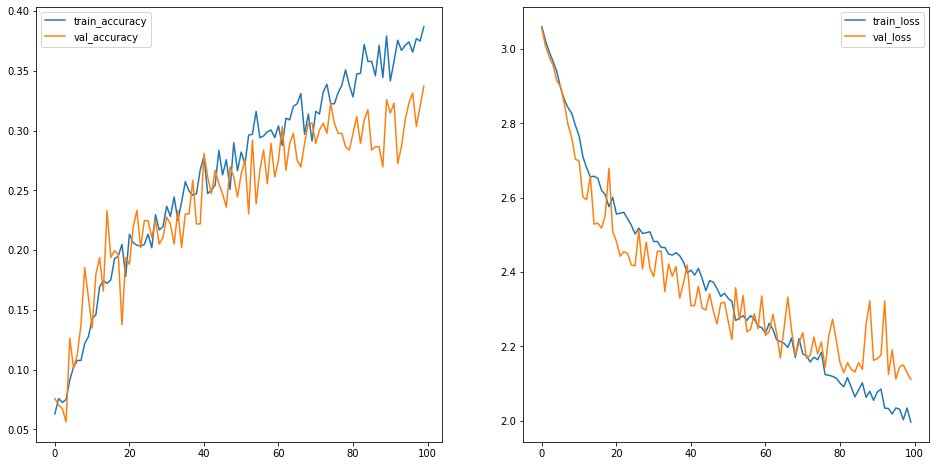

In [34]:
fig, axes = plt.subplots(1, 2, figsize =(16, 8))
axes[0].plot(history_mymodel.history['accuracy'], label='train_accuracy')
axes[0].plot(history_mymodel.history['val_accuracy'], label='val_accuracy')
axes[0].legend()
axes[1].plot(history_mymodel.history['loss'], label='train_loss')
axes[1].plot(history_mymodel.history['val_loss'], label='val_loss')
axes[1].legend()
plt.show()

### Problem 8

### Transfer Learning using VGG16


Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify [tanukis](https://en.wikipedia.org/wiki/Japanese_raccoon_dog). For the following model, we will use VGG16 we learnt in class to be our base model structure, followed by dense layers.

#### Model 3
The model structure should be:
- VGG16 with `imagenet` retrained weights
- Fully Connected Layer with 512 nodes


- Relu
- DropOut Rate 0.25


- Fully Connected Layer with 256 nodes


- Relu
- DropOut Rate 0.25


- Fully Connected Layer with 128 nodes


- Relu
- DropOut Rate 0.25 


- Fully Connected Layer with n nodes (n = number of breeds) and softmax


Here's some code to get you started:
```python
from keras.applications.vgg16 import VGG16
def build_vgg():
  inputshape = X_train[0].shape
  base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=inputshape)
  x = base_model.output
  ### DO EXTRA LAYERS HERE
  model = Model(inputs = base_model.input, outputs = predictions)
  return model
model_vgg = build_vgg()
model_vgg.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg = model_vgg.fit(training_set,
                            steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                            validation_data = testing_set, epochs = 300, verbose = 1)
```


In [35]:
from keras.applications.vgg16 import VGG16
def build_vgg():
  inputshape = X_train[0].shape
  base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=inputshape)
  x = base_model.output
  
  model = Flatten()(x)
  #layer 1
  model = Dense(512, activation = "relu", kernel_initializer="he_normal",input_shape=(image_resize, image_resize, 3))(model)
  model = Dropout(rate=0.25)(model)
  #layer 2
  model = Dense(256, activation = "relu", kernel_initializer="he_normal")(model)
  model = Dropout(rate=0.25)(model)
  #layer 3
  model = Dense(128, activation = "relu", kernel_initializer="he_normal")(model)
  model = Dropout(rate=0.25)(model)
  #layer 4
  predictions = Dense(n_breeds, activation = 'softmax')(model)

  model = Model(inputs = base_model.input, outputs = predictions)
  return model
model_vgg = build_vgg()
model_vgg.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg = model_vgg.fit(training_set,
                            steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                            validation_data = testing_set, epochs = 300, verbose = 1)

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/300
142/142 [==============================] - 9s 53ms/step - loss: 3.1422 - accuracy: 0.0533 - val_loss: 2.7945 - val_accuracy: 0.0871
Epoch 2/300
142/142 [==============================] - 7s 49ms/step - loss: 2.8542 - accuracy: 0.0851 - val_loss: 2.7678 - val_accuracy: 0.0955
Epoch 3/300
142/142 [==============================] - 7s 49ms/step - loss: 2.8200 - accuracy: 0.0748 - val_loss: 2.7623 - val_accuracy: 0.0702
Epoch 4/300
142/142 [==============================] - 7s 49ms/step - loss: 2.7953 - accuracy: 0.0666 - val_loss: 2.7506 - val_accuracy: 0.1067
Epoch 5/300
142/142 [==============================] - 7s 49ms/step - loss: 2.7750 - accuracy: 0.0775 - val_loss: 2.7497 - val_accuracy: 0.0674
Epoch 6/300
142/142 [==============================] - 7s 49ms/step - loss: 2.7655 - accuracy: 0.0758 - val_loss: 2.7454 - val_accuracy: 0.0815
Epoch 7/300
142/142 [==============================] - 7s 50ms/step - l

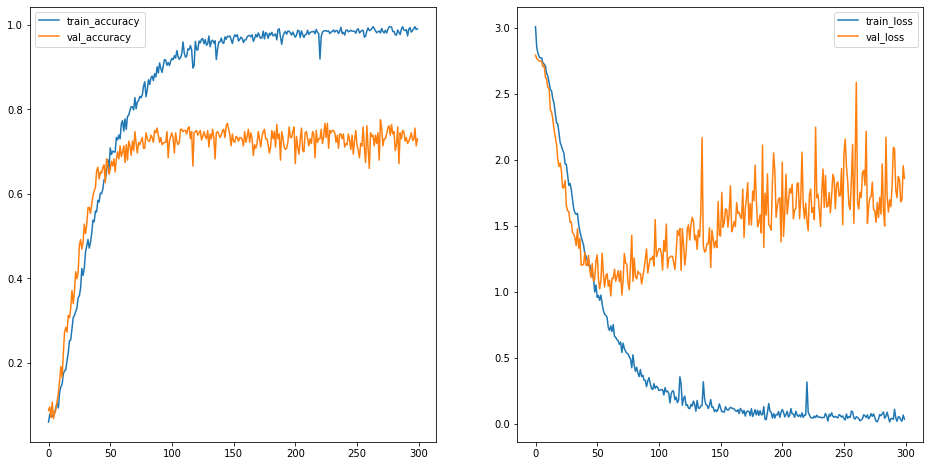

In [36]:
fig, axes = plt.subplots(1, 2, figsize =(16, 8))
axes[0].plot(history_vgg.history['accuracy'], label='train_accuracy')
axes[0].plot(history_vgg.history['val_accuracy'], label='val_accuracy')
axes[0].legend()
axes[1].plot(history_vgg.history['loss'], label='train_loss')
axes[1].plot(history_vgg.history['val_loss'], label='val_loss')
axes[1].legend()
plt.show()

### Check Some of the Predictions


We can check our work in the previous problem by displaying some example images of dogs alongside their actual breed and the model-predicted breed:


```python
j = int(np.sqrt(n_breeds))
i = int(np.ceil(n_breeds / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
classes = list(y_train.columns)

for i, breed in enumerate(list(labels.columns.unique())):
    ax = grid[i]
    img_index = list(y_test[breed]==1).index(True)
    ax.imshow(X_test[img_index])
    x = X_test[img_index].reshape(1,image_resize,image_resize,3)
    preds = model_vgg.predict(x)
    prob = preds.max()
    class_name = classes[np.argmax(preds)]
    ax.text(10, image_resize-15, 'Model Prediction: %s (%.2f)' % (class_name, prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, image_resize-5, 'TRUE LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')

plt.show()
```


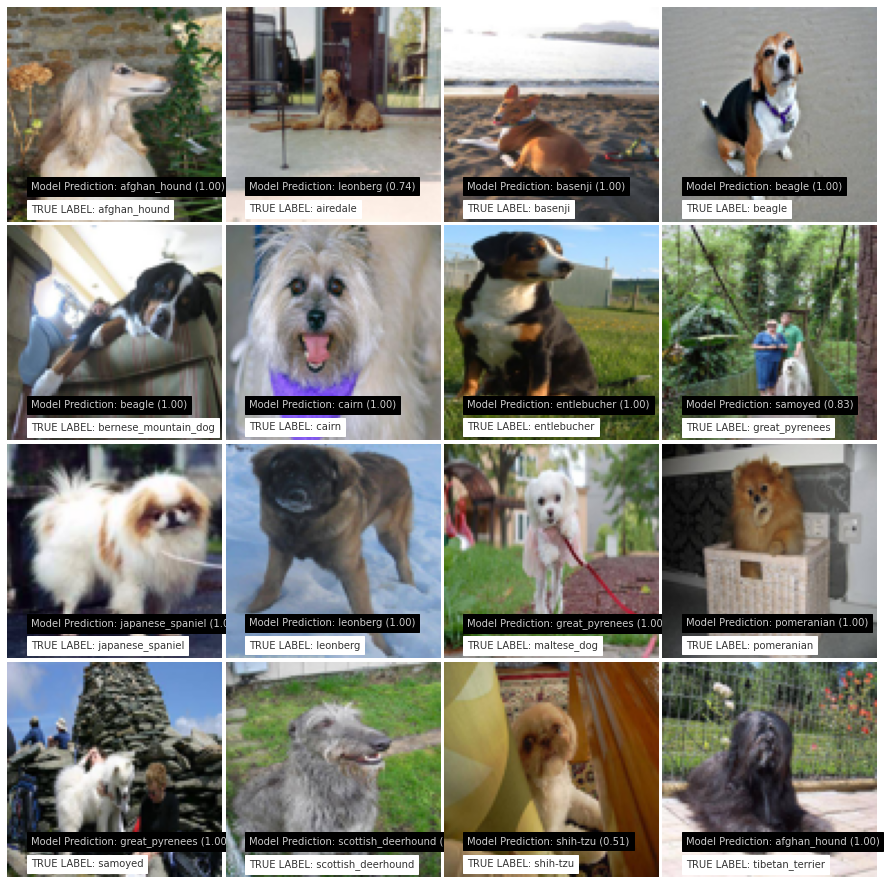

In [37]:
j = int(np.sqrt(n_breeds))
i = int(np.ceil(n_breeds / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
classes = list(y_train.columns)

for i, breed in enumerate(list(labels.columns.unique())):
    ax = grid[i]
    img_index = list(y_test[breed]==1).index(True)
    ax.imshow(X_test[img_index])
    x = X_test[img_index].reshape(1,image_resize,image_resize,3)
    preds = model_vgg.predict(x)
    prob = preds.max()
    class_name = classes[np.argmax(preds)]
    ax.text(10, image_resize-15, 'Model Prediction: %s (%.2f)' % (class_name, prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, image_resize-5, 'TRUE LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')

plt.show()

® Did the transfer learning model outperform the models which were trained from scratch?


The transfer learning model performs much better than the previous models. The training accuracy is around 0.98 and the validation accuracy is around 0.7, which is much higher than the models trained from scratch. 

By checking the prediction, almost all of the predictions are correct with high probability. 


### Problem 9

### Let us finally predict a TA's pet!
® One of our TAs, Becky, has a puppy. This puppy is one of the breeds in our classification model! Load the photo of her and see whether the model can correctly predict the breed!
```python
becky_pet = load_img(path+"becky.jpg", 
                     target_size=(image_resize, image_resize))
becky_pet = img_to_array(becky_pet)/255
plt.imshow(becky_pet)
```


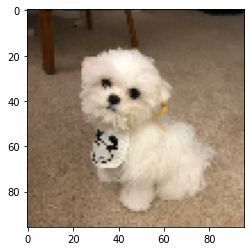

In [38]:
becky_pet = load_img(path+"becky.jpg", 
                     target_size=(image_resize, image_resize))
becky_pet = img_to_array(becky_pet)/255
plt.imshow(becky_pet)

In [39]:
preds = model_vgg.predict(becky_pet.reshape(1,image_resize,image_resize,3))
class_name = classes[np.argmax(preds)]
class_name

'maltese_dog'

### Problem 10

® Try modifying the batch size for the training of the first convnet model. What tradeoffs do you observe, particularly regarding how quickly the model trains?


There is a trade-off between batch size and running time. With smaller batch size, it would take more time to go through one epoch. With larger batch size, it would take less time to go through one epoch. 

However, with larger batch_size, the test accuracy would decrease because the generalization ability would be weaker.

### Problem 11

® In the transfer learning example, we trained the entire network. However, it's common to _freeze_ layers in the base model and only train the layers added on top. You can read about how to do this in Keras [here](https://keras.io/getting_started/faq/#how-can-i-freeze-layers-and-do-finetuning). How does this change affect training time and model performance?


In [40]:
from keras.applications.vgg16 import VGG16
keras.backend.clear_session()
def build_freeze_vgg():
  inputshape = X_train[0].shape
  base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=inputshape)
  x = base_model.output
  for i in base_model.layers:
    i.trainable = False
  model = Flatten()(x)
  #layer 1
  model = Dense(512, activation = "relu", kernel_initializer="he_normal",input_shape=(image_resize, image_resize, 3))(model)
  model = Dropout(rate=0.25)(model)
  #layer 2
  model = Dense(256, activation = "relu", kernel_initializer="he_normal")(model)
  model = Dropout(rate=0.25)(model)
  #layer 3
  model = Dense(128, activation = "relu", kernel_initializer="he_normal")(model)
  model = Dropout(rate=0.25)(model)
  #layer 4
  predictions = Dense(n_breeds, activation="softmax")(model)
  model = Model(inputs = base_model.input, outputs = predictions)
  return model
model_freeze_vgg = build_freeze_vgg()
model_freeze_vgg.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_freeze_vgg = model_freeze_vgg.fit(training_set,
                            steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                            validation_data = testing_set, epochs = 300, verbose = 1)

Epoch 1/300
142/142 [==============================] - 5s 32ms/step - loss: 3.5120 - accuracy: 0.0484 - val_loss: 2.8385 - val_accuracy: 0.0590
Epoch 2/300
142/142 [==============================] - 4s 31ms/step - loss: 3.0351 - accuracy: 0.0745 - val_loss: 2.7829 - val_accuracy: 0.0590
Epoch 3/300
142/142 [==============================] - 4s 30ms/step - loss: 2.9185 - accuracy: 0.0782 - val_loss: 2.7545 - val_accuracy: 0.0843
Epoch 4/300
142/142 [==============================] - 4s 30ms/step - loss: 2.9104 - accuracy: 0.0741 - val_loss: 2.7477 - val_accuracy: 0.0787
Epoch 5/300
142/142 [==============================] - 4s 30ms/step - loss: 2.8366 - accuracy: 0.1048 - val_loss: 2.7356 - val_accuracy: 0.0702
Epoch 6/300
142/142 [==============================] - 4s 30ms/step - loss: 2.8336 - accuracy: 0.0922 - val_loss: 2.7281 - val_accuracy: 0.0787
Epoch 7/300
142/142 [==============================] - 4s 30ms/step - loss: 2.8322 - accuracy: 0.0863 - val_loss: 2.7235 - val_accuracy:

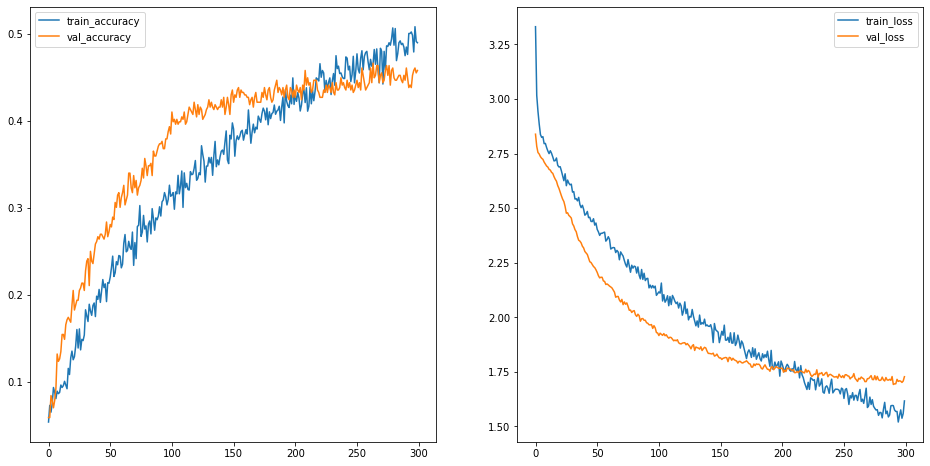

In [41]:
fig, axes = plt.subplots(1, 2, figsize =(16, 8))
axes[0].plot(history_freeze_vgg.history['accuracy'], label='train_accuracy')
axes[0].plot(history_freeze_vgg.history['val_accuracy'], label='val_accuracy')
axes[0].legend()
axes[1].plot(history_freeze_vgg.history['loss'], label='train_loss')
axes[1].plot(history_freeze_vgg.history['val_loss'], label='val_loss')
axes[1].legend()
plt.show()

Th final training accuracy is near 0.5 and the test accuracy is 0.45. Both of them are less than the previous unfreezed model. Thus, the model performs worse than the previous one.

### Problem 12

® Check out [this amazing website](http://www.cs.cmu.edu/~aharley/vis/conv/) by Adam Harley. Choose some digit other than 1 and draw it in the box in the top left part of the window.![](https://firebasestorage.googleapis.com/v0/b/prismia.appspot.com/o/user-images%252FScreen%2520Shot%25202021-02-09%2520at%25209-7822d8b8-c704-4fa5-9352-b5d168c25c9e.png?alt=media&token=4d5dcd27-32fd-43a4-92ea-90864d6273cf)
1. At which layer of the network can you no longer visually recognize the digit?
2. Consider a single neuron in the fourth layer (the one where each box is 5 by 5). How many neurons in previous (third) layer are in that neuron's receptive field?
3. For the same neuron as in part 2: how many neurons in the _second_ layer are in that neuron's receptive field?
4. Try drawing the same digit repeatedly, attempting to make the digit look somewhat different each time (off-enter, or with a smaller loop or a bit of an extra curve somewhere). Are there any units in the penultimate layer which serve as a bellwether, activating strongly when your particular digit is drawn. (Note that you can check a unit's index by clicking on it.)


I choose '8'.
1. At the third layer it is hard to regognize the digit.
2. $2*2 = 4$. There are 4 neurons in the second layer are in that neuron's receptive field.
3. $6*6*4 = 144$ There are 144 neurons in the second layer are in that neuron's receptive field.
4. 
Normal: 20, 33, 46, 57, 76, 77, 91, 96，99    
off-center: 14, 23, 46, 51, 53, 82, 90, 91   
extra-curve in the end: 33, 46, 57, 64, 76, 77, 91, 96, 99  
extra-curve in middle: 20, 33, 39, 46, 57, 64, 76, 77, 91, 96, 99  
Thus, I would say 33, 46, 57, 76, 77, 91, 99 are particularly strong in recognizing digit "8" in this model.


### Problem 13